> The difference-in-differences method is a quasi-experimental approach that compares the changes in outcomes over time between a population enrolled in a program (the treatment group) and a population that is not (the comparison group). It is a useful tool for data analysis.

The dataset is adapted from the dataset in [Card and Krueger (1994)](https://davidcard.berkeley.edu/papers/njmin-aer.pdf), which estimates the causal effect of an increase in the state minimum wage on the employment. 

- On April 1, 1992, New Jersey raised the state minimum wage from 4.25 USD to 5.05 USD while the minimum wage in Pennsylvania stays the same at 4.25 USD. 
- data about employment in fast-food restaurants in NJ (0) and PA (1) were collected in February 1992 and in November 1992. 
- 384 restaurants in total after removing null values

The calculation of DID is simple:

- mean PA (control group) employee per restaurant before/after the treatment is 23.38/21.1, so the after/before difference for the control group is -2.28 (21.1 - 23.38)
- mean NJ (treatment group) employee per restaurant before/after the treatment is 20.43/20.90, so the after/before difference for the treatment group is 0.47 (20.9 - 20.43)
- the difference-in-differences (DID) is 2.75 (0.47 + 2.28), which is (the after/before difference of the treatment group) - (the after/before difference of the control group)

The same DID result can be obtained via regression, which allows adding control variables if needed:

$y = \beta_0 + \beta_1 * g + \beta_2 * t + \beta_3 * (t * g) + \varepsilon$

- g is 0 for the control group and 1 for the treatment group
- t is 0 for before and 1 for after

we can insert the values of g and t using the table below and see that coefficient ($\beta_3$) of the interaction of g and t is the value for DID：

|              | Control Group (g=0) | Treatment Group (g=1)                   |                 |
|--------------|---------------------|-----------------------------------------|-----------------|
| Before (t=0) | $\beta_0$           | $\beta_0 + \beta_1$                     |                 |
| After (t=1)  | $\beta_0 + \beta_2$ | $\beta_0 + \beta_1 + \beta_2 + \beta_3$ |                 |
| Difference   | $\beta_2$           | $\beta_2 + \beta_3$                     | $\beta_3$ (DID) |

The p-value for $\beta_3$ in this example is not significant, which means that the average total employees per restaurant increased after the minimal salary raise by 2.75 FTE (full-time equivalent) but the result may be just due to random factors.

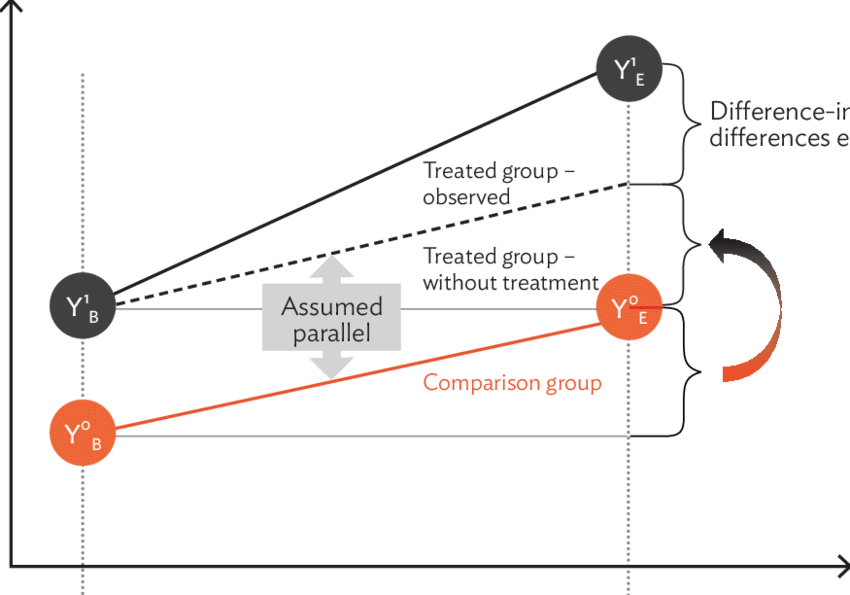

In [18]:
import pandas as pd

| Variable | Description |
|----------|-------------|
| `state` | State indicator: 0 = Pennsylvania (control), 1 = New Jersey (treatment) |
| `total_emp_feb` | Total employees per restaurant in February 1992 (before) |
| `total_emp_nov` | Total employees per restaurant in November 1992 (after) |

In [ ]:
df = pd.read_csv('data/employment.csv')
df.info()

In [20]:
df.head()

,state,total_emp_feb,total_emp_nov
0,0,40.50,24.0
1,0,13.75,11.5
2,0,8.50,10.5
3,0,34.00,20.0
4,0,24.00,35.5


In [21]:
df.groupby('state').mean()

,total_emp_feb,total_emp_nov
state,,
0,23.380000,21.096667
1,20.430583,20.897249


In [22]:
mean_emp_pa_before = df.groupby('state').mean().iloc[0, 0]
mean_emp_pa_after = df.groupby('state').mean().iloc[0, 1]
mean_emp_nj_before = df.groupby('state').mean().iloc[1, 0]
mean_emp_nj_after = df.groupby('state').mean().iloc[1, 1]

print(f'mean PA employment before: {mean_emp_pa_before:.2f}')
print(f'mean PA employment after: {mean_emp_pa_after:.2f}')
print(f'mean NJ employment before: {mean_emp_nj_before:.2f}')
print(f'mean NJ employment after: {mean_emp_nj_after:.2f}')

pa_diff = mean_emp_pa_after - mean_emp_pa_before
nj_diff = mean_emp_nj_after - mean_emp_nj_before
did = nj_diff - pa_diff

print(f'DID in mean employment is {did:.2f}')

mean PA employment before: 23.38
mean PA employment after: 21.10
mean NJ employment before: 20.43
mean NJ employment after: 20.90
DID in mean employment is 2.75


## Key Assumptions of DID Analysis

The validity of DID estimates depends on several critical assumptions:

### 1. Parallel Trends Assumption

**The most important assumption**: In the absence of the policy, the treated and control groups would have followed the same trend over time.

$$E[y_{i,\text{after}}^0 | g_i = 1] - E[y_{i,\text{before}}^0 | g_i = 1] = E[y_{i,\text{after}}^0 | g_i = 0] - E[y_{i,\text{before}}^0 | g_i = 0]$$

**In our example**: Pennsylvania's employment decline reflects the trend fast-food employment would have followed in New Jersey without the minimum wage increase.

**Potential violation**: If New Jersey's fast-food industry was already outperforming Pennsylvania's (perhaps due to better locations or different consumer preferences), then Pennsylvania's trend may not be an appropriate counterfactual.

**How to check**: Examine pre-policy trends over multiple periods. If trends diverge before treatment, the assumption is questionable.

### 2. No Anticipation

Policy effects should not occur before the policy is implemented. If restaurants in New Jersey anticipated the wage increase and adjusted behavior beforehand, our before-period measurement would not capture the true pre-policy baseline.

**How to check**: Use leads of treatment (observations before the official implementation date) to test for pre-treatment responses.

### 3. Treatment Timing is Clearly Defined

We must be able to identify when treatment begins and observe outcomes clearly before and after.

**In our example**: The April 1, 1992 date is clear, and surveys in February and November bracket the change appropriately.

### 4. No Spillovers

The policy should not affect the control group. Ideally, control units are geographically distant or operate in completely separate markets from treated units.

**In our example**: A potential concern is whether consumers or labor might flow between NJ and PA, or if regional economic shocks affect both states identically.

### 5. Sample Composition Remains Constant

We ideally observe the same units (restaurants) in both periods. If units exit or enter the sample differentially between groups, estimates may be biased.

**In our example**: Some restaurants may have closed between February and November. If closures were differential between states (perhaps due to selection into the treatment effect), estimates could be biased.

In [23]:
# group g: 0 control group (PA), 1 treatment group (NJ)
# t: 0 before treatment (min wage raise), 1 after treatment
# gt: interaction of g * t

# data before the treatment
df_before = df[['total_emp_feb', 'state']]
df_before['t'] = 0
df_before.columns = ['total_emp', 'g', 't']

# data after the treatment
df_after = df[['total_emp_nov', 'state']]
df_after['t'] = 1
df_after.columns = ['total_emp', 'g', 't']

# data for regression
df_reg = pd.concat([df_before, df_after])

# create the interaction 
df_reg['gt'] = df_reg.g * df_reg.t

df_reg

,total_emp,g,t,gt
0,40.50,0,0,0
1,13.75,0,0,0
2,8.50,0,0,0
3,34.00,0,0,0
4,24.00,0,0,0
...,...,...,...,...
379,23.75,1,1,1
380,17.50,1,1,1
381,20.50,1,1,1
382,20.50,1,1,1


In [24]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

X = df_reg[['g', 't', 'gt']]
y = df_reg.total_emp

lr.fit(X, y)
lr.coef_  # the coefficient for gt is the DID, which is 2.75

array([-2.94941748, -2.28333333,  2.75      ])

In [25]:
from statsmodels.formula.api import ols
ols = ols('total_emp ~ g + t + gt', data=df_reg).fit()
print(ols.summary())

                            OLS Regression Results                            
Dep. Variable:              total_emp   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.947
Date:                Wed, 19 Nov 2025   Prob (F-statistic):              0.121
Time:                        12:28:50   Log-Likelihood:                -2817.6
No. Observations:                 768   AIC:                             5643.
Df Residuals:                     764   BIC:                             5662.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     23.3800      1.098     21.288      0.0

In [27]:
df['unit_id'] = range(len(df))
df['treated'] = df['state']  # 0=control, 1=treatment

# Преобразовать в long format
df_long = pd.concat([
    df[['unit_id', 'treated', 'state']].assign(time=0, employment=df['total_emp_feb']),
    df[['unit_id', 'treated', 'state']].assign(time=1, employment=df['total_emp_nov'])
], ignore_index=True)

# Создать DID переменную
df_long['did'] = df_long['treated'] * df_long['time']

print("Long format data:")
print(f"Shape: {df_long.shape}")
print(f"Observations by group:\n{df_long.groupby(['treated', 'time']).size()}")

Long format data:
Shape: (768, 6)
Observations by group:
treated  time
0        0        75
         1        75
1        0       309
         1       309
dtype: int64


In [33]:
control_before = df_long[(df_long['treated'] == 0) & (df_long['time'] == 0)]['employment'].mean()
control_after = df_long[(df_long['treated'] == 0) & (df_long['time'] == 1)]['employment'].mean()
treat_before = df_long[(df_long['treated'] == 1) & (df_long['time'] == 0)]['employment'].mean()
treat_after = df_long[(df_long['treated'] == 1) & (df_long['time'] == 1)]['employment'].mean()

four_cell = pd.DataFrame({
    'Before (February)': [control_before, treat_before],
    'After (November)': [control_after, treat_after],
    'Change': [control_after - control_before, treat_after - treat_before]
}, index=['Control (State 0)', 'Treatment (State 1)'])

did_manual = (treat_after - treat_before) - (control_after - control_before)
print(f"  Treatment Change:  {treat_after - treat_before:+.3f}")
print(f"  Control Change:    {control_after - control_before:+.3f}")
print(f"  ─────────────────────────")
print(f"  DID Estimate:      {did_manual:+.3f}")

  Treatment Change:  +0.467
  Control Change:    -2.283
  ─────────────────────────
  DID Estimate:      +2.750


(-0.2, 1.2)

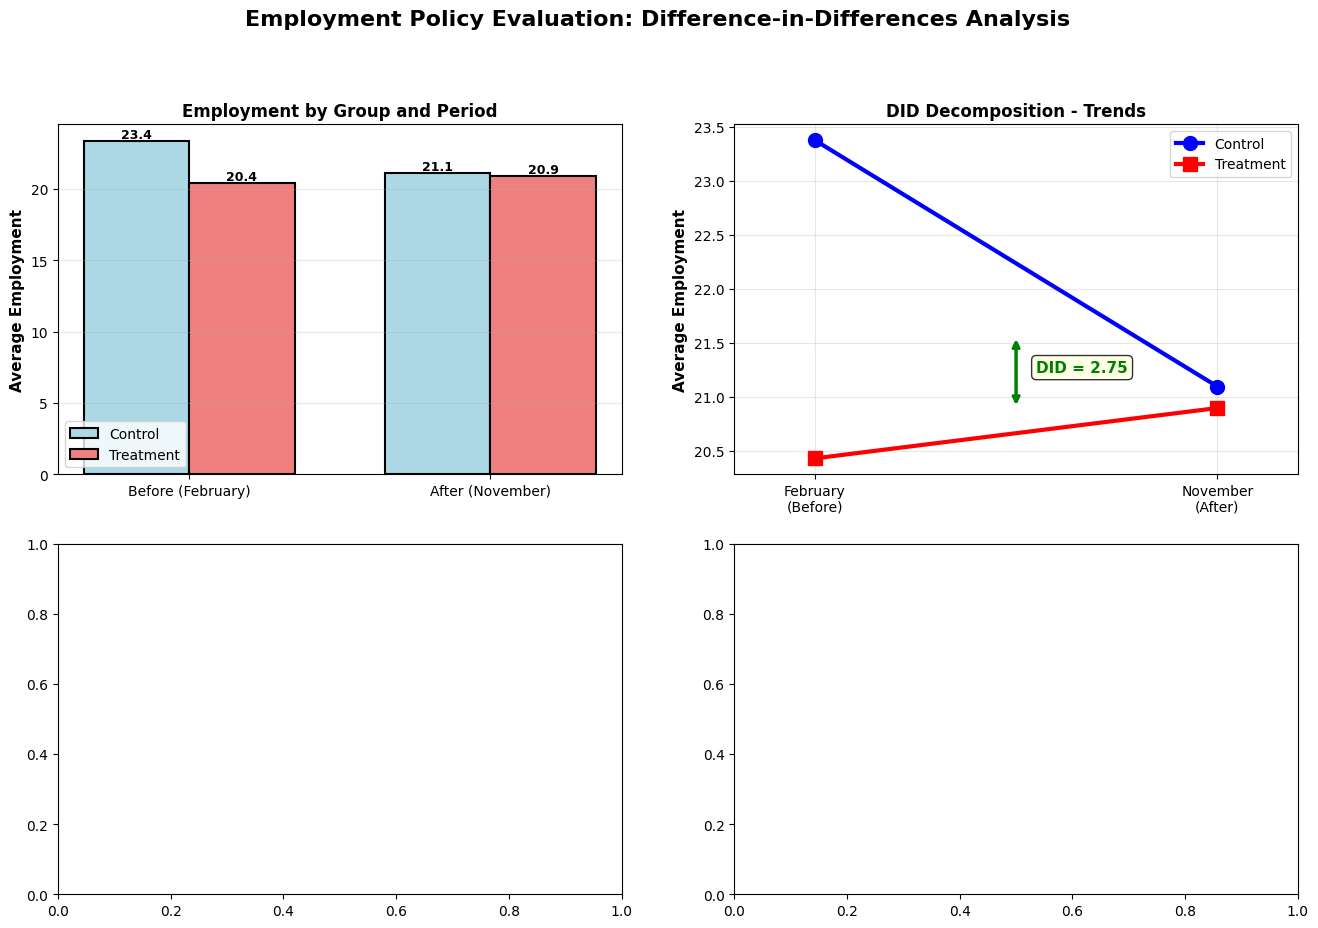

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 2, figsize=(16, 10))
fig.suptitle('Employment Policy Evaluation: Difference-in-Differences Analysis', 
             fontsize=16, fontweight='bold', y=0.995)

ax1 = axes[0, 0]

means_data = four_cell[['Before (February)', 'After (November)']].T
x = np.arange(len(means_data.columns))
width = 0.35

bars1 = ax1.bar(x - width/2, means_data['Control (State 0)'], width, 
               label='Control', color='lightblue', edgecolor='black', linewidth=1.5)
bars2 = ax1.bar(x + width/2, means_data['Treatment (State 1)'], width,
               label='Treatment', color='lightcoral', edgecolor='black', linewidth=1.5)

ax1.set_ylabel('Average Employment', fontweight='bold', fontsize=11)
ax1.set_title('Employment by Group and Period', fontweight='bold', fontsize=12)
ax1.set_xticks(x)
ax1.set_xticklabels(means_data.index)
ax1.legend(fontsize=10)
ax1.grid(axis='y', alpha=0.3)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')
for bar in bars2:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
            f'{height:.1f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax2 = axes[0, 1]

periods = [0, 1]
ax2.plot(periods, [control_before, control_after], 'b-o', linewidth=3, 
        markersize=10, label='Control', zorder=3)
ax2.plot(periods, [treat_before, treat_after], 'r-s', linewidth=3,
        markersize=10, label='Treatment', zorder=3)

mid = 0.5
ax2.annotate('', xy=(mid, treat_after), xytext=(mid, control_after + (treat_after - treat_before)),
            arrowprops=dict(arrowstyle='<->', color='green', lw=2.5))
ax2.text(mid + 0.05, (treat_after + control_after + (treat_after - treat_before))/2,
        f'DID = {did_manual:.2f}', fontsize=11, color='green', fontweight='bold',
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8))

ax2.set_xticks([0, 1])
ax2.set_xticklabels(['February\n(Before)', 'November\n(After)'])
ax2.set_ylabel('Average Employment', fontweight='bold', fontsize=11)
ax2.set_title('DID Decomposition - Trends', fontweight='bold', fontsize=12)
ax2.legend(fontsize=10, loc='best')
ax2.grid(True, alpha=0.3)
ax2.set_xlim(-0.2, 1.2)